# Santander Customer Transaction Prediction
Hi, this kernel produces a top 5 submission with public/private LB of 0.92569/0.92446 running in 1.5 hours on kaggle servers. It was written in a very short time thus containing some mistakes which aren't edited. This achievement wouldn't have been possible without the huge insights and inspiration I gained from many great kernels / discussions, thank you! I also want to thank my teammates interneuron and Chua Cheng Hong for helping me getting the most out of this kernel and collectively achieving 3rd place in this competition. 

# Imports

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold,KFold
from scipy.stats import norm, skew

from tqdm import tqdm_notebook as tqdm
from copy import copy
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Loading Data
At this point I filter out the fakes (shoutout to YaG320) and concatenate train and test for future FE. Setting `use_experimental = True` splits the Train data into train / test which was useful for later NN training indicating whether a model is overfitting. I wasn't sure if the fakes are going to be used for final score evaluation, so I also applied all the transformations to them and kept them in a separate dataframe. 

In [2]:
use_experimental = False

train_df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')

indices_fake = np.load('../input/list-of-fake-samples-and-public-private-lb-split/synthetic_samples_indexes.npy')
indices_pub = np.load('../input/list-of-fake-samples-and-public-private-lb-split/public_LB.npy')
indices_pri = np.load('../input/list-of-fake-samples-and-public-private-lb-split/private_LB.npy')
indices_real = np.concatenate([indices_pub, indices_pri])

features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target_train = train_df['target']
X_train = train_df
X_test = test_df.loc[indices_real,:]
X_test['target'] = np.zeros(X_test.shape[0])
X_fake = test_df.loc[indices_fake,:]
X_fake['target'] = np.zeros(X_test.shape[0])
train_length = X_train.shape[0]
target_test = X_test['target']
target_fake = X_fake['target']

if use_experimental:
    np.random.seed(42)    
    indices = np.arange(train_length)
    train_length = 150000
    np.random.shuffle(indices)
    indices_train = indices[:train_length]
    indices_test = indices[train_length:]
    # Swapped order to not overwrite X_train to soon
    X_test = X_train.iloc[indices_test,:]
    X_fake = X_train.iloc[indices_test,:]
    target_fake = X_fake['target']
    X_train = X_train.iloc[indices_train,:]
    target_train = X_train['target']
    target_test = X_test['target']

X_all = pd.concat([X_train, X_test])
print(X_all.shape)

(300000, 202)


# Feature Engineering

## Counts, Density, Deviation
Here I calculate the unique counts of each faeture seaparately. Based on that I also calculate the density by smoothing the counts and also the deviation as counts/density.

In [3]:
import scipy.ndimage

sigma_fac = 0.001
sigma_base = 4

eps = 0.00000001

def get_count(X_all, X_fake):
    features_count = np.zeros((X_all.shape[0], len(features)))
    features_density = np.zeros((X_all.shape[0], len(features)))
    features_deviation = np.zeros((X_all.shape[0], len(features)))

    features_count_fake = np.zeros((X_fake.shape[0], len(features)))
    features_density_fake = np.zeros((X_fake.shape[0], len(features)))
    features_deviation_fake = np.zeros((X_fake.shape[0], len(features)))
    
    sigmas = []

    for i,var in enumerate(tqdm(features)):
        X_all_var_int = (X_all[var].values * 10000).round().astype(int)
        X_fake_var_int = (X_fake[var].values * 10000).round().astype(int)
        lo = X_all_var_int.min()
        X_all_var_int -= lo
        X_fake_var_int -= lo
        hi = X_all_var_int.max()+1
        counts_all = np.bincount(X_all_var_int, minlength=hi).astype(float)
        zeros = (counts_all == 0).astype(int)
        before_zeros = np.concatenate([zeros[1:],[0]])
        indices_all = np.arange(counts_all.shape[0])
        # Geometric mean of twice sigma_base and a sigma_scaled which is scaled to the length of array 
        sigma_scaled = counts_all.shape[0]*sigma_fac
        sigma = np.power(sigma_base * sigma_base * sigma_scaled, 1/3)
        sigmas.append(sigma)
        counts_all_smooth = scipy.ndimage.filters.gaussian_filter1d(counts_all, sigma)
        deviation = counts_all / (counts_all_smooth+eps)
        indices = X_all_var_int
        features_count[:,i] = counts_all[indices]
        features_density[:,i] = counts_all_smooth[indices]
        features_deviation[:,i] = deviation[indices]
        indices_fake = X_fake_var_int
        features_count_fake[:,i] = counts_all[indices_fake]
        features_density_fake[:,i] = counts_all_smooth[indices_fake]
        features_deviation_fake[:,i] = deviation[indices_fake]
        
    features_count_names = [var+'_count' for var in features]
    features_density_names = [var+'_density' for var in features]
    features_deviation_names = [var+'_deviation' for var in features]

    X_all_count = pd.DataFrame(columns=features_count_names, data = features_count)
    X_all_count.index = X_all.index
    X_all_density = pd.DataFrame(columns=features_density_names, data = features_density)
    X_all_density.index = X_all.index
    X_all_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation)
    X_all_deviation.index = X_all.index
    X_all = pd.concat([X_all,X_all_count, X_all_density, X_all_deviation], axis=1)
    
    X_fake_count = pd.DataFrame(columns=features_count_names, data = features_count_fake)
    X_fake_count.index = X_fake.index
    X_fake_density = pd.DataFrame(columns=features_density_names, data = features_density_fake)
    X_fake_density.index = X_fake.index
    X_fake_deviation = pd.DataFrame(columns=features_deviation_names, data = features_deviation_fake)
    X_fake_deviation.index = X_fake.index
    X_fake = pd.concat([X_fake,X_fake_count, X_fake_density, X_fake_deviation], axis=1)    

    features_count = features_count_names
    features_density = features_density_names
    features_deviation = features_deviation_names
    return X_all, features_count, features_density, features_deviation, X_fake

X_all, features_count, features_density, features_deviation, X_fake = get_count(X_all, X_fake)
print(X_all.shape)


(300000, 802)


## Target encoding (unused)


In [ ]:
# # Also try to encode counts themselves

# weighting = 500
# n_splits = 2

# features_to_encode = features_count

# def get_encoding(X_all):
#     arr_all_int = (X_all[features_to_encode].values * 10000).round().astype(int)
#     arr_target_train = target_train.values 
#     arr_target_test = target_test.values
    
#     preds_oof = np.zeros((train_length, len(features)))
#     preds_test = np.zeros((arr_all_int.shape[0] - train_length, len(features)))
#     preds_train = np.zeros((train_length, len(features)))
    
#     for v ,var in enumerate(tqdm(features_to_encode)):
#         lo = arr_all_int[:,v].min()
#         arr_all_var = arr_all_int[:,v] - lo
#         hi = arr_all_var.max() + 1
#         arr_train_var = arr_all_var[:train_length]
#         arr_test_var = arr_all_var[train_length:]
#         folds = StratifiedKFold(n_splits=n_splits, shuffle=True)
#         for train_idx, val_idx in folds.split(arr_train_var, arr_target_train):
#             X_tr = arr_train_var[train_idx]
#             y_tr = arr_target_train[train_idx]
#             X_val = arr_train_var[val_idx]
#             y_val = arr_target_train[val_idx]
#             X_ts = arr_test_var
#             arr1 = X_tr[y_tr == 1]        
#             mean = arr1.shape[0] / X_tr.shape[0]
#             hits = np.bincount(arr1, minlength=hi).astype(float)
#             base = np.bincount(X_tr, minlength=hi).astype(float)
#             lamb = base / (base + weighting)
#             expected_target = (hits / (base+0.00000001)) * lamb + (1-lamb) * mean              

#             prediction_oof = expected_target[X_val]
#             prediction_test = expected_target[X_ts]
#             prediction_train = expected_target[X_tr]
#             preds_oof[val_idx,v] += prediction_oof 
#             preds_test[:,v] += prediction_test 
#             preds_train[train_idx,v] += prediction_train 
#         score_running_oof = roc_auc_score(arr_target_train, preds_oof.mean(axis=1))
#         score_running_test = roc_auc_score(arr_target_test, preds_test.mean(axis=1))
#         score_running_train = roc_auc_score(arr_target_train, preds_train.mean(axis=1))
        
#     preds_all = np.concatenate([preds_oof, preds_test], axis=0)
#     feature_names = [var+'_encoding' for var in features_to_encode]
#     X_all_encoding = pd.DataFrame(columns=feature_names, data = preds_all)
#     X_all_encoding.index = X_all.index
#     X_all = pd.concat([X_all,X_all_encoding], axis=1)
#     return X_all, feature_names

# X_all, features_encoding = get_encoding(X_all)

# print(X_all.shape)

## NB predictor (unused)

In [ ]:
# def compress(arr, indices, thresh = 100000):
#     old_length = arr.shape[0] 
#     fac = old_length // thresh
#     if fac < 1:
#         return arr, indices
#     new_length = int(np.ceil(old_length / fac))+2
#     new_arr = np.zeros(new_length * fac)
#     new_arr[fac:old_length+fac] = arr
#     new_arr = new_arr.reshape(new_length, fac).sum(axis=1)
#     index_shift = indices[0]-0.5*(fac-1)-1
#     new_indices = np.arange(new_length) * fac + index_shift
#     return new_arr, new_indices    

# def transform_grouper(counts_orig, indices_orig, min_elems=10):
#     first_ind, first_count, last_ind, last_count = indices_orig[0], counts_orig[0], indices_orig[-1], counts_orig[-1]
#     indices = indices_orig[1:-1]
#     counts = counts_orig[1:-1]
#     new_indices = [np.array([first_ind])]
#     cur_indices = []
#     cur_counts = 0
#     for i, count in enumerate(counts):
#         cur_indices.append(indices[i])
#         cur_counts += count
#         if cur_counts >= min_elems:
#             new_indices.append(np.array(cur_indices))
#             cur_counts = 0
#             cur_indices = []
#     if cur_indices:
#         new_indices.append(np.array(cur_indices))
#     new_indices.append(np.array([last_ind]))
#     return new_indices

# def transform_space(counts, indices_grouped):
#     new_counts = []
#     new_indices = []
#     for arr_index in indices_grouped:
#         count = counts[arr_index]
#         count_sum = np.sum(count)
#         if count_sum > 0:
#             new_indices.append(np.sum(arr_index*count)/count_sum)
#         else:
#             new_indices.append(np.mean(arr_index))
#         new_counts.append(count_sum)
#     return np.array(new_counts), np.array(new_indices)

# def get_hist(arr, indices_grouped):
#     hi = indices_grouped[-1][0] + 1
#     counts = np.bincount(arr, minlength=hi)
#     indices = np.arange(counts.shape[0])
#     counts, indices = transform_space(counts, indices_grouped)
#     return counts / counts.sum(), indices

# def get_density_func(kde, indices, sigma=0.0001, resolution=2000):
#     kde_smooth = scipy.ndimage.filters.gaussian_filter1d(kde,sigma*len(indices))
#     return scipy.interpolate.interp1d(indices, kde_smooth, kind='linear')

# def get_p_x_t(x, t, density_funcs):
#     return density_funcs[t](x) 

# def get_p_1_x(x, density_funcs, prior=0.1, eps=0.00000000000000001):
#     p_x_0 = get_p_x_t(x,0,density_funcs)
#     p_x_1 = get_p_x_t(x,1,density_funcs)
#     p_x = (p_x_1*prior + p_x_0*(1-prior)+eps)
#     return p_x_1*prior / p_x, p_x

# import scipy.ndimage
# import scipy

# n_splits = 2

# def get_NB_predictor(X_all):   
#     arr_all_int = (X_all[features].values * 10000).round().astype(int)
#     arr_target_train = target_train.values 
#     arr_target_test = target_test.values
#     preds_oof = np.zeros((train_length, len(features)))
#     preds_test = np.zeros((arr_all_int.shape[0] - train_length, len(features)))
#     preds_train = np.zeros((train_length, len(features)))
#     for v, var in enumerate(features):
#         lo = arr_all_int[:,v].min()
#         arr_all_var = arr_all_int[:,v] - lo
#         hi = arr_all_var.max() + 1
#         arr_train_var = arr_all_var[:train_length]
#         arr_test_var = arr_all_var[train_length:]
#         counts_all = np.bincount(arr_all_var, minlength=hi)
#         indices_all = np.arange(counts_all.shape[0])
#         min_elems = [20]
#         sigmas = [0.05,0.02,0.005,0.002]
#         preds_oof_temp = np.zeros((preds_oof.shape[0], len(sigmas), len(min_elems)))
#         preds_test_temp = np.zeros((preds_test.shape[0], len(sigmas), len(min_elems)))
#         preds_train_temp = np.zeros((preds_train.shape[0], len(sigmas), len(min_elems)))
#         for j,min_elem in enumerate(min_elems):
#             indices_grouped = transform_grouper(counts_all, indices_all, min_elems=min_elem)            
#             kfold = StratifiedKFold(n_splits=n_splits, shuffle=False, random_state = np.random.randint(10000))
#             for train_idx, val_idx in kfold.split(arr_train_var, arr_target_train):
#                 X_tr = arr_train_var[train_idx]
#                 y_tr = arr_target_train[train_idx]
#                 X_val = arr_train_var[val_idx]
#                 y_val = arr_target_train[val_idx]
#                 X_ts = arr_test_var
#                 arr0 = X_tr[y_tr == 0]
#                 arr1 = X_tr[y_tr == 1]
#                 prior = arr1.shape[0] / (arr1.shape[0] + arr0.shape[0]) 
#                 kde0, indices0 = get_hist(arr0, indices_grouped)
#                 kde1, indices1 = get_hist(arr1, indices_grouped)
#                 for i,sigma in enumerate(sigmas): 
#                     density_func0 = get_density_func(kde0, indices0, sigma=sigma)
#                     density_func1 = get_density_func(kde1, indices1, sigma=sigma)
#                     prediction_oof, confidence = get_p_1_x(X_val, [density_func0, density_func1], prior=prior)
#                     prediction_test, confidence = get_p_1_x(X_ts, [density_func0, density_func1], prior=prior)
#                     prediction_train, confidence = get_p_1_x(X_tr, [density_func0, density_func1], prior=prior)
#                     preds_oof_temp[val_idx,i,j] += prediction_oof 
#                     preds_test_temp[:,i,j] += prediction_test 
#                     preds_train_temp[train_idx,i,j] += prediction_train 
#         scores = np.zeros((len(sigmas), len(min_elems)))
#         for i in range(len(sigmas)):
#             for j in range(len(min_elems)):
#                 scores[i,j] = log_loss(arr_target_train, preds_oof_temp[:,i,j])
#         sorted_indices = np.dstack(np.unravel_index(np.argsort(scores.ravel()), (len(sigmas), len(min_elems))))[0]
#         preds_oof[:,v] = preds_oof_temp[:,sorted_indices[0,0], sorted_indices[0,1]]
#         preds_test[:,v] = preds_test_temp[:,sorted_indices[0,0], sorted_indices[0,1]]
#         preds_train[:,v] = preds_train_temp[:,sorted_indices[0,0], sorted_indices[0,1]]
#         score_running_oof = roc_auc_score(arr_target_train, preds_oof.mean(axis=1))
#         score_running_test = roc_auc_score(arr_target_test, preds_test.mean(axis=1))
#         score_running_train = roc_auc_score(arr_target_train, preds_train.mean(axis=1))
#         print(var, sorted_indices[0], score_running_oof, score_running_test, score_running_train)
#     preds_all = np.concatenate([preds_oof, preds_test], axis=0)
#     feature_names = [var+'_pred' for var in features]
#     X_all_pred = pd.DataFrame(columns=feature_names, data = preds_all)
#     X_all_pred.index = X_all.index
#     X_all = pd.concat([X_all,X_all_pred], axis=1)
#     return X_all, feature_names
        
# X_all, features_pred = get_NB_predictor(X_all)

# print(X_all.shape)

## Standardize
I standardize all the features (or supposedly so, apparently I forgot density and deviation being in time trouble). Which is important for later NN usage.

In [4]:
features_to_scale = [features, features_count]

from sklearn.preprocessing import StandardScaler

def get_standardized(X_all, X_fake):
    scaler = StandardScaler()
    features_to_scale_flatten = [var for sublist in features_to_scale for var in sublist]
    scaler.fit(X_all[features_to_scale_flatten])
    features_scaled = scaler.transform(X_all[features_to_scale_flatten])
    features_scaled_fake = scaler.transform(X_fake[features_to_scale_flatten])
    X_all[features_to_scale_flatten] = features_scaled
    X_fake[features_to_scale_flatten] = features_scaled_fake
    return X_all, X_fake

X_all, X_fake = get_standardized(X_all, X_fake)

print(X_all.shape)

(300000, 802)


## Rotated features (unused)


In [12]:
# features_to_rot = [features, features_count]
# angles = [np.pi/4]

# def get_rotated(X_all):
#     list_features_rot = []
#     list_X_all_rot = [] 
#     for j ,angle in enumerate(angles):
#         list_rot_0 = []
#         list_rot_1 = []
#         feature_names_0 = []
#         feature_names_1 = []
#         c,s = np.cos(angle), np.sin(angle)
#         rot_mat = np.array([[c,-s],[s,c]])
#         for i in tqdm(range(len(features))):
#             vars_to_rot = [feat[i] for feat in features_to_rot]
#             arr = X_all[vars_to_rot].values
#             arr_rot = np.dot(arr, rot_mat)
#             list_rot_0.append(arr_rot[:,0])
#             list_rot_1.append(arr_rot[:,1])
#             feature_names_0.append('var_%d_angle_%d_rot_0' %(i,j))        
#             feature_names_1.append('var_%d_angle_%d_rot_1' %(i,j))        
#         arr_rot_0 = np.stack(list_rot_0).transpose()
#         arr_rot_1 = np.stack(list_rot_1).transpose()
#         list_features_rot.append(feature_names_0)
#         list_features_rot.append(feature_names_1)
#         X_all_rot_0 = pd.DataFrame(columns=feature_names_0, data = arr_rot_0)
#         X_all_rot_0.index = X_all.index
#         X_all_rot_1 = pd.DataFrame(columns=feature_names_1, data = arr_rot_1)
#         X_all_rot_1.index = X_all.index
#         list_X_all_rot.append(X_all_rot_0)
#         list_X_all_rot.append(X_all_rot_1)

#     X_all_rot = pd.concat(list_X_all_rot, axis=1)
#     X_all = pd.concat([X_all, X_all_rot], axis=1)
#     return X_all, feature_names_0, feature_names_1

# X_all, feature_names_rot_0, feature_names_rot_1 = get_rotated(X_all)

# print(X_all.shape)

## PCA (unused)

In [6]:
# features_to_pca = [features, features_count]

# from sklearn.decomposition import PCA

# def get_pca(X_all):
#     list_X_all_pca = [] 
#     list_pca_0 = []
#     list_pca_1 = []
#     feature_names_0 = []
#     feature_names_1 = []
#     for i in tqdm(range(len(features))):
#         vars_to_pca = [feat[i] for feat in features_to_rot]
#         arr = X_all[vars_to_pca].values
#         pca = PCA(n_components = 2)
#         arr_pca = pca.fit_transform(arr)
#         list_pca_0.append(arr_pca[:,0])
#         list_pca_1.append(arr_pca[:,1])
#         feature_names_0.append('var_%d_pca_0' %i)        
#         feature_names_1.append('var_%d_pca_1' %i)        
#     arr_pca_0 = np.stack(list_pca_0).transpose()
#     arr_pca_1 = np.stack(list_pca_1).transpose()
#     X_all_pca_0 = pd.DataFrame(columns=feature_names_0, data = arr_pca_0)
#     X_all_pca_0.index = X_all.index
#     X_all_pca_1 = pd.DataFrame(columns=feature_names_1, data = arr_pca_1)
#     X_all_pca_1.index = X_all.index
#     list_X_all_pca.append(X_all_pca_0)
#     list_X_all_pca.append(X_all_pca_1)

#     X_all_pca = pd.concat(list_X_all_pca, axis=1)
#     X_all = pd.concat([X_all, X_all_pca], axis=1)
#     return X_all, feature_names_0, feature_names_1

# X_all, feature_names_pca_0, feature_names_pca_1 = get_pca(X_all)

# print(X_all.shape)

## Setting up Dataframes
After performing FE on `X_all`, I split it back into train/test and delete the obsolete dataframe. The latter is a reoccuring theme in this kernel and was necessary as I often experienced memory overflow. This is also the reason why I wrote most of the code inside of functions. Shoutout to kaggle however for providing fast GPUs!

In [7]:
X_train = X_all.iloc[:train_length,:]
X_test = X_all.iloc[train_length:,:]
del X_all
import gc
gc.collect()
print(X_train.shape, X_test.shape)

(200000, 802) (100000, 802)


# LGBM 
Many public kernels indicated that the features are independent, conditional on the target. For this reason I train seperate trees for each feature and their respective counts. Using a simple average (of the square root) of all tree predictors achieves around 0.9225 / 0.9205 on public/private LB.

In [ ]:
features_used = [features, features_count]

## Params
Parameters of the LGBM model. I choose l1 regularization / max_bin / learning rate and num_leaves seaprately for each of the 200 var_x through earlier hyperparam search.

In [9]:
params = {
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1,
    'learning_rate': 0.08,
    'max_depth': -1,
    'metric':'binary_logloss',
    'num_leaves': 4,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'reg_alpha': 2,
    'reg_lambda': 0,
    'verbosity': 1,
    'max_bin':256,
}

# reg_alpha
reg_alpha_values = [0.75, 1, 2, 3]
reg_alpha_var = [3, 0, 2, 3, 2, 0, 1, 1, 3, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 3, 3, 2, 1, 3, 1, 3, 2, 2, 3, 1, 1, 3, 2, 0, 1, 0, 2, 1, 1, 2, 3, 0, 3, 3, 3, 2, 0, 3, 1, 3, 1, 1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 1, 3, 2, 0, 2, 1, 2, 0, 0, 1, 3, 3, 1, 2, 3, 3, 2, 0, 1, 2, 3, 3, 2, 3, 3, 0, 0, 3, 0, 1, 0, 1, 0, 2, 3, 1, 0, 3, 1, 3, 2, 3, 1, 3, 3, 3, 1, 3, 2, 3, 2, 1, 0, 1, 2, 0, 3, 0, 3, 0, 3, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 3, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 2, 3, 2, 3, 1, 1, 3, 1, 1, 2, 1, 2, 0, 3, 1, 3, 3, 2, 0, 1, 3, 3, 0, 1, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 0, 0, 0, 3, 0, 3, 0, 0, 2, 0, 3, 1, 0, 3, 2]

# max_bin
max_bin_values = [256, 512, 1024]
max_bin_var = [0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 2]

# learning_rate
learning_rate_values = [0.06, 0.08, 0.12]
learning_rate_var = [2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]

# num_leaves
num_leaves_values = [3, 4, 5]
num_leaves_var = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 2, 1, 2]



## Training

A little discussion I had with Chua in this markdown cell. Thats probably not the most efficient way of communicating :D.

Chua:

One interesting finding is that any var with AUC lower than 0.504 does not help the model in any way. I checked the naive bayes kernel and they were the 'saw-like' probability curves. Went but to magic ecdf kernel and they were those that have ecdf that lined up a bit too perfectly. Considering that we are training features one by one. I think it may make sense to actually remove them all together.

Nawid:

I think your explanation is generally correct, however I would not exclude them already during training especially because you do it separately for every fold, I believe this leads to some sort of overfitting thus leading to differences in CV and LB, I also think that it is better practice to remove them **after** the trees are trained for example with a Lasso model. Moreover I believe that using AUC as validation metric for early stopping leads to overfitting CV. I therefore removed this part of the code and only train a single model. Similarly a very high number of early stopping rounds can also lead to overfitting.

In [11]:
n_folds = 5
early_stopping_rounds=10
settings = [4]
np.random.seed(47)

settings_best_ind = []

def train_trees():
    preds_oof = np.zeros((len(X_train), len(features)))
    preds_test = np.zeros((len(X_test), len(features)))
    preds_train = np.zeros((len(X_train), len(features)))
    preds_fake = np.zeros((len(X_fake), len(features)))

    features_used_flatten = [var for sublist in features_used for var in sublist]
    X_train_used = X_train[features_used_flatten]
    X_test_used = X_test[features_used_flatten]
    X_fake_used = X_fake[features_used_flatten]

    for i in range(len(features)):
        params['max_bin'] = max_bin_values[max_bin_var[i]]
        params['learning_rate'] = learning_rate_values[learning_rate_var[i]]
        params['reg_alpha'] = reg_alpha_values[reg_alpha_var[i]]
        params['num_leaves'] = num_leaves_values[num_leaves_var[i]]
        features_train = [feature_set[i] for feature_set in features_used] 
        print(f'Training on: {features_train}')
        folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=np.random.randint(100000))
        list_folds = list(folds.split(X_train_used.values, target_train.values))
        preds_oof_temp = np.zeros((preds_oof.shape[0], len(settings)))
        preds_test_temp = np.zeros((preds_test.shape[0], len(settings)))
        preds_train_temp = np.zeros((preds_train.shape[0], len(settings)))
        preds_fake_temp = np.zeros((preds_fake.shape[0], len(settings)))

        scores = []
        for j, setting in enumerate(settings):
            # setting is used for hyperparameter tuning, here you can add sometinh like params['num_leaves'] = setting
            print('\nsetting: ', setting)
            for k, (trn_idx, val_idx) in enumerate(list_folds):
                print("Fold: {}".format(k+1), end="")
                trn_data = lgb.Dataset(X_train_used.iloc[trn_idx][features_train], label=target_train.iloc[trn_idx])
                val_data = lgb.Dataset(X_train_used.iloc[val_idx][features_train], label=target_train.iloc[val_idx])

                # Binary Log Loss
                clf = lgb.train(params, trn_data, 2000, valid_sets=[trn_data, val_data], verbose_eval=False, early_stopping_rounds=early_stopping_rounds) 

                prediction_val1 = clf.predict(X_train_used.iloc[val_idx][features_train])
                prediction_test1 = clf.predict(X_test_used[features_train])
                prediction_train1 = clf.predict(X_train_used.iloc[trn_idx][features_train])
                prediction_fake1 = clf.predict(X_fake_used[features_train])

                # Predictions
                s1 = roc_auc_score(target_train.iloc[val_idx], prediction_val1)
                s1_log = log_loss(target_train.iloc[val_idx], prediction_val1)
                print(' - val AUC: {:<8.4f} - loss: {:<8.3f}'.format(s1, s1_log*1000), end='')

                # Predictions Test
                if use_experimental:
                    s1_test = roc_auc_score(target_test, prediction_test1)
                    s1_log_test = log_loss(target_test, prediction_test1)
                    print(' - test AUC: {:<8.4f} - loss: {:<8.3f}'.format(s1_test, s1_log_test*1000), end='')

                # Predictions Train
                s1_train = roc_auc_score(target_train.iloc[trn_idx], prediction_train1)
                s1_log_train = log_loss(target_train.iloc[trn_idx], prediction_train1)
                print(' - train AUC: {:<8.4f} - loss: {:<8.3f}'.format(s1_train, s1_log_train*1000), end='')
                if use_experimental:
                    print('',clf.feature_importance(), end='')

                print('')


                preds_oof_temp[val_idx,j] += np.sqrt(prediction_val1 - prediction_val1.mean() + 0.1) 
                preds_test_temp[:,j] += np.sqrt(prediction_test1 - prediction_test1.mean() + 0.1) / n_folds
                preds_train_temp[trn_idx,j] += np.sqrt(prediction_train1 - prediction_train1.mean() + 0.1) / (n_folds-1)
                preds_fake_temp[:,j] += np.sqrt(prediction_fake1 - prediction_fake1.mean() + 0.1) / n_folds

            score_setting = roc_auc_score(target_train, preds_oof_temp[:,j])
            score_setting_log = 1000*log_loss(target_train, np.exp(preds_oof_temp[:,j]))
            scores.append(score_setting_log)
            print("Score:  - val AUC: {:<8.4f} - loss: {:<8.3f}".format(score_setting, score_setting_log), end='')
            if use_experimental:
                score_setting_test = roc_auc_score(target_test, preds_test_temp[:,j])
                score_setting_log_test = 1000*log_loss(target_test, np.exp(preds_test_temp[:,j]))  
                print(" - test AUC: {:<8.4f} - loss: {:<8.3f}".format(score_setting_test, score_setting_log_test), end='')

            score_setting_train = roc_auc_score(target_train, preds_train_temp[:,j])
            score_setting_log_train = 1000*log_loss(target_train, np.exp(preds_train_temp[:,j]))
            print(" - train AUC: {:<8.4f} - loss: {:<8.3f}".format(score_setting_train, score_setting_log_train))

        best_ind = np.argmin(scores)
        settings_best_ind.append(best_ind)
        preds_oof[:,i] = preds_oof_temp[:,best_ind]
        preds_test[:,i] = preds_test_temp[:,best_ind]
        preds_train[:,i] = preds_train_temp[:,best_ind]
        preds_fake[:,i] = preds_fake_temp[:,best_ind]


        print('\nbest setting: ', settings[best_ind])
        preds_oof_cum = preds_oof[:,:i+1].mean(axis=1)
        print("Cum CV val  : {:<8.4f} - loss: {:<8.3f}".format(roc_auc_score(target_train, preds_oof_cum), 1000*log_loss(target_train, np.exp(preds_oof_cum))))
        if use_experimental:        
            preds_test_cum = preds_test[:,:i+1].mean(axis=1)
            print("Cum CV test : {:<8.4f} - loss: {:<8.3f}".format(roc_auc_score(target_test, preds_test_cum), 1000*log_loss(target_test, np.exp(preds_test_cum))))
        preds_train_cum = preds_train[:,:i+1].mean(axis=1)
        print("Cum CV train: {:<8.4f} - loss: {:<8.3f}".format(roc_auc_score(target_train, preds_train_cum), 1000*log_loss(target_train, np.exp(preds_train_cum))))
        print('*****' * 10 + '\n')
        
    return preds_oof, preds_test, preds_train, preds_fake

preds_oof, preds_test, preds_train, preds_fake = train_trees()

Training on: ['var_0', 'var_0_count']

setting:  4
Fold: 1 - val AUC: 0.5582   - loss: 323.269  - train AUC: 0.5552   - loss: 323.639 
Fold: 2 - val AUC: 0.5479   - loss: 323.996  - train AUC: 0.5552   - loss: 323.584 
Fold: 3 - val AUC: 0.5419   - loss: 324.190  - train AUC: 0.5561   - loss: 323.559 
Fold: 4 - val AUC: 0.5524   - loss: 323.488  - train AUC: 0.5569   - loss: 323.556 
Fold: 5 - val AUC: 0.5482   - loss: 324.035  - train AUC: 0.5592   - loss: 323.411 
Score:  - val AUC: 0.5491   - loss: 31068.694 - train AUC: 0.5585   - loss: 31068.694

best setting:  4
Cum CV val  : 0.5491   - loss: 31068.694
Cum CV train: 0.5585   - loss: 31068.694
**************************************************

Training on: ['var_1', 'var_1_count']

setting:  4
Fold: 1 - val AUC: 0.5547   - loss: 323.721  - train AUC: 0.5492   - loss: 323.713 
Fold: 2 - val AUC: 0.5396   - loss: 324.233  - train AUC: 0.5529   - loss: 323.625 
Fold: 3 - val AUC: 0.5418   - loss: 324.060  - train AUC: 0.5534   - los

Fold: 5 - val AUC: 0.5173   - loss: 325.820  - train AUC: 0.5283   - loss: 325.373 
Score:  - val AUC: 0.5187   - loss: 31068.694 - train AUC: 0.5309   - loss: 31068.694

best setting:  4
Cum CV val  : 0.6437   - loss: 31068.694
Cum CV train: 0.6567   - loss: 31068.694
**************************************************

Training on: ['var_12', 'var_12_count']

setting:  4
Fold: 1 - val AUC: 0.5540   - loss: 323.411  - train AUC: 0.5672   - loss: 322.234 
Fold: 2 - val AUC: 0.5679   - loss: 322.053  - train AUC: 0.5635   - loss: 322.572 
Fold: 3 - val AUC: 0.5528   - loss: 323.602  - train AUC: 0.5655   - loss: 322.260 
Fold: 4 - val AUC: 0.5571   - loss: 322.422  - train AUC: 0.5658   - loss: 322.517 
Fold: 5 - val AUC: 0.5694   - loss: 321.897  - train AUC: 0.5635   - loss: 322.627 
Score:  - val AUC: 0.5589   - loss: 31068.694 - train AUC: 0.5667   - loss: 31068.694

best setting:  4
Cum CV val  : 0.6605   - loss: 31068.694
Cum CV train: 0.6730   - loss: 31068.694
*******************

Fold: 1 - val AUC: 0.5220   - loss: 325.693  - train AUC: 0.5286   - loss: 325.547 
Fold: 2 - val AUC: 0.5255   - loss: 325.705  - train AUC: 0.5291   - loss: 325.495 
Fold: 3 - val AUC: 0.5230   - loss: 325.765  - train AUC: 0.5272   - loss: 325.540 
Fold: 4 - val AUC: 0.5245   - loss: 325.652  - train AUC: 0.5280   - loss: 325.607 
Fold: 5 - val AUC: 0.5241   - loss: 325.750  - train AUC: 0.5283   - loss: 325.546 
Score:  - val AUC: 0.5233   - loss: 31068.694 - train AUC: 0.5299   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7054   - loss: 31068.694
Cum CV train: 0.7214   - loss: 31068.694
**************************************************

Training on: ['var_24', 'var_24_count']

setting:  4
Fold: 1 - val AUC: 0.5349   - loss: 325.332  - train AUC: 0.5387   - loss: 325.155 
Fold: 2 - val AUC: 0.5253   - loss: 325.402  - train AUC: 0.5402   - loss: 325.076 
Fold: 3 - val AUC: 0.5241   - loss: 325.611  - train AUC: 0.5389   - loss: 325.113 
Fold: 4 - val AUC: 0.5320   - loss: 3

Score:  - val AUC: 0.5452   - loss: 31068.694 - train AUC: 0.5513   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7348   - loss: 31068.694
Cum CV train: 0.7532   - loss: 31068.694
**************************************************

Training on: ['var_35', 'var_35_count']

setting:  4
Fold: 1 - val AUC: 0.5395   - loss: 324.911  - train AUC: 0.5416   - loss: 324.953 
Fold: 2 - val AUC: 0.5279   - loss: 325.542  - train AUC: 0.5418   - loss: 324.900 
Fold: 3 - val AUC: 0.5326   - loss: 325.398  - train AUC: 0.5396   - loss: 324.931 
Fold: 4 - val AUC: 0.5417   - loss: 324.991  - train AUC: 0.5408   - loss: 324.942 
Fold: 5 - val AUC: 0.5358   - loss: 324.902  - train AUC: 0.5396   - loss: 325.063 
Score:  - val AUC: 0.5348   - loss: 31068.694 - train AUC: 0.5428   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7378   - loss: 31068.694
Cum CV train: 0.7565   - loss: 31068.694
**************************************************

Training on: ['var_36', 'var_36_count']

setting:  

Fold: 2 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 5 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7569   - loss: 31068.694
Cum CV train: 0.7766   - loss: 31068.694
**************************************************

Training on: ['var_47', 'var_47_count']

setting:  4
Fold: 1 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 5 - val AUC: 0.5000   - loss: 6

Score:  - val AUC: 0.5133   - loss: 31068.694 - train AUC: 0.5256   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7769   - loss: 31068.694
Cum CV train: 0.7989   - loss: 31068.694
**************************************************

Training on: ['var_58', 'var_58_count']

setting:  4
Fold: 1 - val AUC: 0.5213   - loss: 325.905  - train AUC: 0.5338   - loss: 325.395 
Fold: 2 - val AUC: 0.5236   - loss: 325.905  - train AUC: 0.5327   - loss: 325.447 
Fold: 3 - val AUC: 0.5299   - loss: 325.536  - train AUC: 0.5310   - loss: 325.510 
Fold: 4 - val AUC: 0.5275   - loss: 325.553  - train AUC: 0.5318   - loss: 325.507 
Fold: 5 - val AUC: 0.5313   - loss: 325.433  - train AUC: 0.5308   - loss: 325.522 
Score:  - val AUC: 0.5259   - loss: 31068.694 - train AUC: 0.5331   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7780   - loss: 31068.694
Cum CV train: 0.8003   - loss: 31068.694
**************************************************

Training on: ['var_59', 'var_59_count']

setting:  

Fold: 2 - val AUC: 0.4976   - loss: 326.046  - train AUC: 0.5206   - loss: 325.773 
Fold: 3 - val AUC: 0.5070   - loss: 325.917  - train AUC: 0.5223   - loss: 325.762 
Fold: 4 - val AUC: 0.5055   - loss: 325.991  - train AUC: 0.5189   - loss: 325.747 
Fold: 5 - val AUC: 0.5006   - loss: 326.082  - train AUC: 0.5212   - loss: 325.783 
Score:  - val AUC: 0.5032   - loss: 31068.694 - train AUC: 0.5241   - loss: 31068.694

best setting:  4
Cum CV val  : 0.7844   - loss: 31068.694
Cum CV train: 0.8104   - loss: 31068.694
**************************************************

Training on: ['var_70', 'var_70_count']

setting:  4
Fold: 1 - val AUC: 0.5228   - loss: 325.551  - train AUC: 0.5301   - loss: 325.143 
Fold: 2 - val AUC: 0.5279   - loss: 325.237  - train AUC: 0.5310   - loss: 325.209 
Fold: 3 - val AUC: 0.5355   - loss: 325.150  - train AUC: 0.5316   - loss: 325.180 
Fold: 4 - val AUC: 0.5206   - loss: 325.418  - train AUC: 0.5317   - loss: 325.170 
Fold: 5 - val AUC: 0.5278   - loss: 3

Score:  - val AUC: 0.5581   - loss: 31068.694 - train AUC: 0.5644   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8071   - loss: 31068.694
Cum CV train: 0.8333   - loss: 31068.694
**************************************************

Training on: ['var_81', 'var_81_count']

setting:  4
Fold: 1 - val AUC: 0.5734   - loss: 320.931  - train AUC: 0.5788   - loss: 320.743 
Fold: 2 - val AUC: 0.5681   - loss: 321.454  - train AUC: 0.5769   - loss: 320.684 
Fold: 3 - val AUC: 0.5680   - loss: 320.892  - train AUC: 0.5777   - loss: 320.877 
Fold: 4 - val AUC: 0.5757   - loss: 321.369  - train AUC: 0.5807   - loss: 320.591 
Fold: 5 - val AUC: 0.5808   - loss: 320.378  - train AUC: 0.5776   - loss: 320.872 
Score:  - val AUC: 0.5731   - loss: 31068.694 - train AUC: 0.5798   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8156   - loss: 31068.694
Cum CV train: 0.8404   - loss: 31068.694
**************************************************

Training on: ['var_82', 'var_82_count']

setting:  

Fold: 2 - val AUC: 0.5427   - loss: 324.361  - train AUC: 0.5476   - loss: 323.763 
Fold: 3 - val AUC: 0.5412   - loss: 324.317  - train AUC: 0.5492   - loss: 323.766 
Fold: 4 - val AUC: 0.5439   - loss: 323.780  - train AUC: 0.5485   - loss: 323.893 
Fold: 5 - val AUC: 0.5475   - loss: 323.806  - train AUC: 0.5483   - loss: 323.903 
Score:  - val AUC: 0.5415   - loss: 31068.694 - train AUC: 0.5500   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8317   - loss: 31068.694
Cum CV train: 0.8570   - loss: 31068.694
**************************************************

Training on: ['var_93', 'var_93_count']

setting:  4
Fold: 1 - val AUC: 0.5338   - loss: 325.107  - train AUC: 0.5372   - loss: 324.984 
Fold: 2 - val AUC: 0.5184   - loss: 325.534  - train AUC: 0.5404   - loss: 324.882 
Fold: 3 - val AUC: 0.5244   - loss: 325.336  - train AUC: 0.5378   - loss: 324.954 
Fold: 4 - val AUC: 0.5341   - loss: 325.139  - train AUC: 0.5371   - loss: 324.952 
Fold: 5 - val AUC: 0.5337   - loss: 3

Cum CV val  : 0.8417   - loss: 31068.694
Cum CV train: 0.8670   - loss: 31068.694
**************************************************

Training on: ['var_104', 'var_104_count']

setting:  4
Fold: 1 - val AUC: 0.5268   - loss: 325.719  - train AUC: 0.5309   - loss: 325.634 
Fold: 2 - val AUC: 0.5240   - loss: 325.775  - train AUC: 0.5304   - loss: 325.600 
Fold: 3 - val AUC: 0.5287   - loss: 325.742  - train AUC: 0.5308   - loss: 325.567 
Fold: 4 - val AUC: 0.5207   - loss: 325.859  - train AUC: 0.5325   - loss: 325.585 
Fold: 5 - val AUC: 0.5260   - loss: 325.723  - train AUC: 0.5305   - loss: 325.596 
Score:  - val AUC: 0.5247   - loss: 31068.694 - train AUC: 0.5323   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8422   - loss: 31068.694
Cum CV train: 0.8676   - loss: 31068.694
**************************************************

Training on: ['var_105', 'var_105_count']

setting:  4
Fold: 1 - val AUC: 0.5174   - loss: 325.857  - train AUC: 0.5334   - loss: 325.420 
Fold: 2 - val 

Fold: 3 - val AUC: 0.5454   - loss: 324.530  - train AUC: 0.5511   - loss: 324.240 
Fold: 4 - val AUC: 0.5409   - loss: 324.763  - train AUC: 0.5511   - loss: 324.177 
Fold: 5 - val AUC: 0.5455   - loss: 324.396  - train AUC: 0.5505   - loss: 324.301 
Score:  - val AUC: 0.5439   - loss: 31068.694 - train AUC: 0.5536   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8595   - loss: 31068.694
Cum CV train: 0.8841   - loss: 31068.694
**************************************************

Training on: ['var_116', 'var_116_count']

setting:  4
Fold: 1 - val AUC: 0.5255   - loss: 325.657  - train AUC: 0.5296   - loss: 325.576 
Fold: 2 - val AUC: 0.5158   - loss: 325.856  - train AUC: 0.5288   - loss: 325.618 
Fold: 3 - val AUC: 0.5231   - loss: 325.801  - train AUC: 0.5273   - loss: 325.584 
Fold: 4 - val AUC: 0.5243   - loss: 325.706  - train AUC: 0.5298   - loss: 325.585 
Fold: 5 - val AUC: 0.5248   - loss: 325.772  - train AUC: 0.5295   - loss: 325.587 
Score:  - val AUC: 0.5221   - loss:

Cum CV val  : 0.8687   - loss: 31068.694
Cum CV train: 0.8935   - loss: 31068.694
**************************************************

Training on: ['var_127', 'var_127_count']

setting:  4
Fold: 1 - val AUC: 0.5328   - loss: 324.968  - train AUC: 0.5460   - loss: 324.489 
Fold: 2 - val AUC: 0.5373   - loss: 324.782  - train AUC: 0.5440   - loss: 324.515 
Fold: 3 - val AUC: 0.5421   - loss: 324.714  - train AUC: 0.5432   - loss: 324.506 
Fold: 4 - val AUC: 0.5434   - loss: 324.481  - train AUC: 0.5466   - loss: 324.456 
Fold: 5 - val AUC: 0.5372   - loss: 324.894  - train AUC: 0.5468   - loss: 324.447 
Score:  - val AUC: 0.5381   - loss: 31068.694 - train AUC: 0.5468   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8703   - loss: 31068.694
Cum CV train: 0.8949   - loss: 31068.694
**************************************************

Training on: ['var_128', 'var_128_count']

setting:  4
Fold: 1 - val AUC: 0.5191   - loss: 325.618  - train AUC: 0.5298   - loss: 325.391 
Fold: 2 - val 

Fold: 3 - val AUC: 0.5205   - loss: 325.829  - train AUC: 0.5249   - loss: 325.639 
Fold: 4 - val AUC: 0.5211   - loss: 325.727  - train AUC: 0.5249   - loss: 325.681 
Fold: 5 - val AUC: 0.5194   - loss: 325.846  - train AUC: 0.5257   - loss: 325.628 
Score:  - val AUC: 0.5172   - loss: 31068.694 - train AUC: 0.5273   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8777   - loss: 31068.694
Cum CV train: 0.9024   - loss: 31068.694
**************************************************

Training on: ['var_139', 'var_139_count']

setting:  4
Fold: 1 - val AUC: 0.5745   - loss: 321.605  - train AUC: 0.5786   - loss: 320.906 
Fold: 2 - val AUC: 0.5717   - loss: 321.748  - train AUC: 0.5805   - loss: 320.896 
Fold: 3 - val AUC: 0.5779   - loss: 321.216  - train AUC: 0.5796   - loss: 320.956 
Fold: 4 - val AUC: 0.5744   - loss: 321.014  - train AUC: 0.5794   - loss: 321.070 
Fold: 5 - val AUC: 0.5780   - loss: 320.793  - train AUC: 0.5799   - loss: 321.031 
Score:  - val AUC: 0.5748   - loss:

Cum CV train: 0.9152   - loss: 31068.694
**************************************************

Training on: ['var_150', 'var_150_count']

setting:  4
Fold: 1 - val AUC: 0.5127   - loss: 325.880  - train AUC: 0.5364   - loss: 325.185 
Fold: 2 - val AUC: 0.5282   - loss: 325.315  - train AUC: 0.5335   - loss: 325.309 
Fold: 3 - val AUC: 0.5274   - loss: 325.568  - train AUC: 0.5310   - loss: 325.333 
Fold: 4 - val AUC: 0.5309   - loss: 325.388  - train AUC: 0.5315   - loss: 325.323 
Fold: 5 - val AUC: 0.5239   - loss: 325.737  - train AUC: 0.5331   - loss: 325.273 
Score:  - val AUC: 0.5227   - loss: 31068.694 - train AUC: 0.5350   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8922   - loss: 31068.694
Cum CV train: 0.9158   - loss: 31068.694
**************************************************

Training on: ['var_151', 'var_151_count']

setting:  4
Fold: 1 - val AUC: 0.5318   - loss: 325.112  - train AUC: 0.5299   - loss: 325.234 
Fold: 2 - val AUC: 0.5300   - loss: 325.351  - train AU

Fold: 4 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 5 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.8963   - loss: 31068.694
Cum CV train: 0.9201   - loss: 31068.694
**************************************************

Training on: ['var_162', 'var_162_count']

setting:  4
Fold: 1 - val AUC: 0.5364   - loss: 325.133  - train AUC: 0.5328   - loss: 325.107 
Fold: 2 - val AUC: 0.5290   - loss: 325.188  - train AUC: 0.5376   - loss: 324.983 
Fold: 3 - val AUC: 0.5321   - loss: 325.200  - train AUC: 0.5351   - loss: 325.054 
Fold: 4 - val AUC: 0.5250   - loss: 325.415  - train AUC: 0.5394   - loss: 324.883 
Fold: 5 - val AUC: 0.5269   - loss: 325.376  - train AUC: 0.5385   - loss: 324.888 
Score:  - val AUC: 0.5289   - loss: 31068.694 - train AUC: 0.5389   - loss: 31068.694

best setting:  4
Cum CV val  : 0

Fold: 1 - val AUC: 0.5320   - loss: 324.957  - train AUC: 0.5463   - loss: 324.276 
Fold: 2 - val AUC: 0.5450   - loss: 324.607  - train AUC: 0.5425   - loss: 324.403 
Fold: 3 - val AUC: 0.5426   - loss: 324.283  - train AUC: 0.5454   - loss: 324.361 
Fold: 4 - val AUC: 0.5372   - loss: 324.744  - train AUC: 0.5451   - loss: 324.323 
Fold: 5 - val AUC: 0.5416   - loss: 324.547  - train AUC: 0.5434   - loss: 324.381 
Score:  - val AUC: 0.5389   - loss: 31068.694 - train AUC: 0.5459   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9085   - loss: 31068.694
Cum CV train: 0.9308   - loss: 31068.694
**************************************************

Training on: ['var_174', 'var_174_count']

setting:  4
Fold: 1 - val AUC: 0.5569   - loss: 321.968  - train AUC: 0.5570   - loss: 322.442 
Fold: 2 - val AUC: 0.5583   - loss: 322.183  - train AUC: 0.5571   - loss: 322.395 
Fold: 3 - val AUC: 0.5513   - loss: 322.945  - train AUC: 0.5575   - loss: 322.262 
Fold: 4 - val AUC: 0.5454   - loss:

Score:  - val AUC: 0.5481   - loss: 31068.694 - train AUC: 0.5559   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9156   - loss: 31068.694
Cum CV train: 0.9370   - loss: 31068.694
**************************************************

Training on: ['var_185', 'var_185_count']

setting:  4
Fold: 1 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 2 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 3 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 4 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Fold: 5 - val AUC: 0.5000   - loss: 693.147  - train AUC: 0.5000   - loss: 693.147 
Score:  - val AUC: 0.5000   - loss: 31068.694 - train AUC: 0.5000   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9156   - loss: 31068.694
Cum CV train: 0.9370   - loss: 31068.694
**************************************************

Training on: ['var_186', 'var_186_count']

settin

Fold: 2 - val AUC: 0.5152   - loss: 325.750  - train AUC: 0.5282   - loss: 325.291 
Fold: 3 - val AUC: 0.5168   - loss: 325.555  - train AUC: 0.5280   - loss: 325.323 
Fold: 4 - val AUC: 0.5206   - loss: 325.392  - train AUC: 0.5279   - loss: 325.333 
Fold: 5 - val AUC: 0.5265   - loss: 325.325  - train AUC: 0.5247   - loss: 325.377 
Score:  - val AUC: 0.5210   - loss: 31068.694 - train AUC: 0.5288   - loss: 31068.694

best setting:  4
Cum CV val  : 0.9213   - loss: 31068.694
Cum CV train: 0.9423   - loss: 31068.694
**************************************************

Training on: ['var_197', 'var_197_count']

setting:  4
Fold: 1 - val AUC: 0.5356   - loss: 325.153  - train AUC: 0.5411   - loss: 324.777 
Fold: 2 - val AUC: 0.5344   - loss: 325.061  - train AUC: 0.5428   - loss: 324.702 
Fold: 3 - val AUC: 0.5276   - loss: 325.214  - train AUC: 0.5400   - loss: 324.861 
Fold: 4 - val AUC: 0.5321   - loss: 325.030  - train AUC: 0.5388   - loss: 324.860 
Fold: 5 - val AUC: 0.5266   - loss:

## Training Summary

In [ ]:
preds_oof_cum = np.zeros(preds_oof.shape[0])
if use_experimental:
    preds_test_cum = np.zeros(preds_test.shape[0])
preds_train_cum = np.zeros(preds_train.shape[0])
for i in range(len(features)):
    preds_oof_cum += preds_oof[:,i]
    preds_train_cum += preds_train[:,i]
    print("var_{} Cum val: {:<8.5f}".format(i,roc_auc_score(target_train, preds_oof_cum)), end="")
    if use_experimental:
        preds_test_cum += preds_test[:,i]
        print(" - test : {:<8.5f}".format(roc_auc_score(target_test, preds_test_cum)), end="")
    print(" - train: {:<8.5f}".format(roc_auc_score(target_train, preds_train_cum)))

In [ ]:
print(settings)
print(settings_best_ind)

## EDA on predictors
I plotted the predictions (sorted by feature), of the trees seaparately for the first 20 vars (x-axis corresponds to the z-score). The predictions are very noisy at the tails of the distributions, therefore I also tried using smoothed predictions (orange line) with no success however.

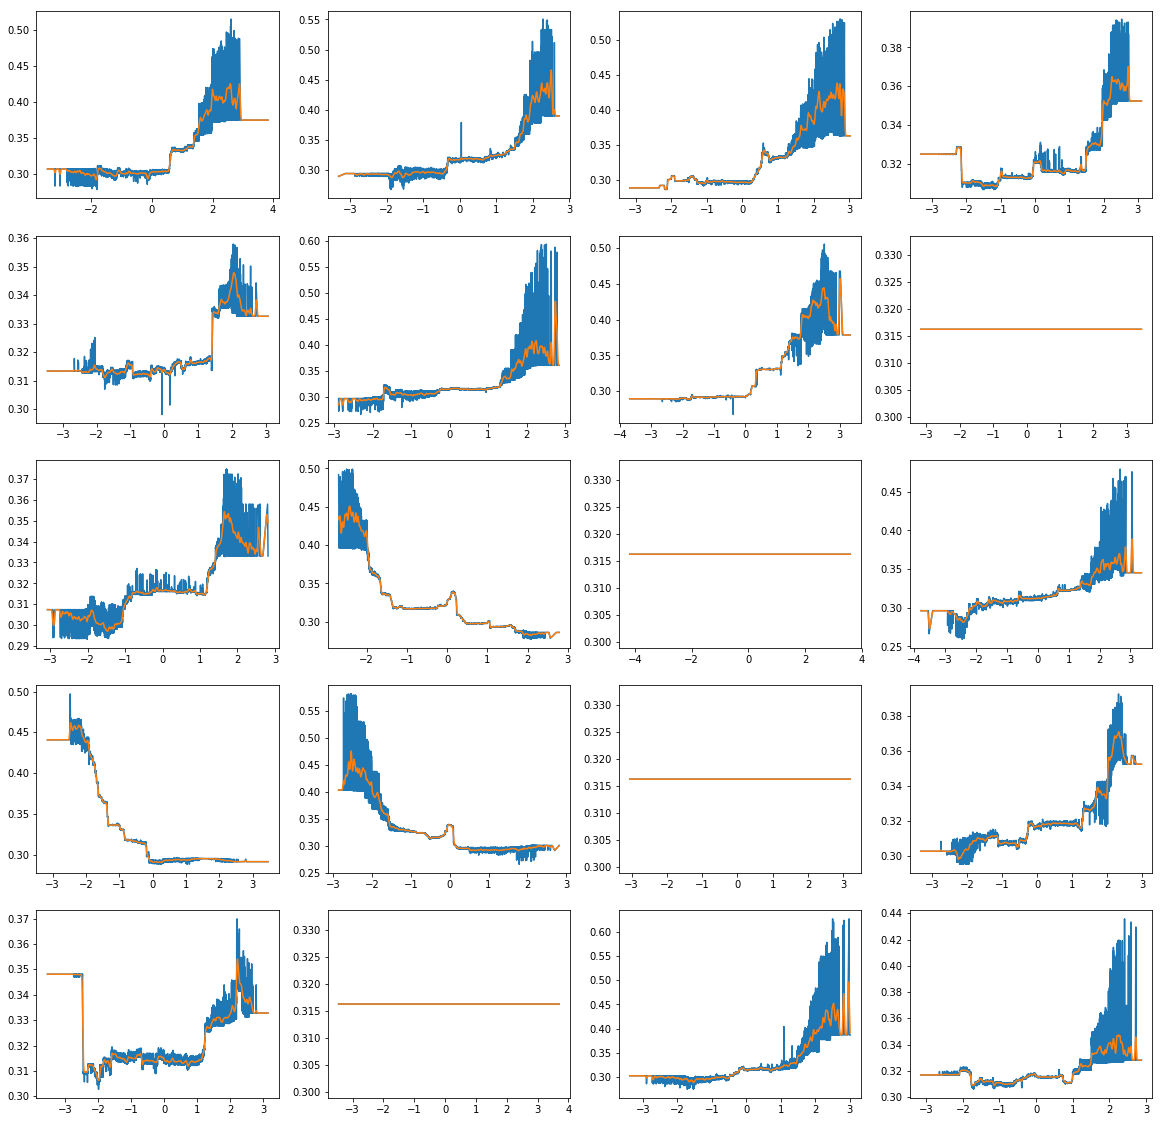

In [15]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt 

features_to_show = np.arange(20)
plt.figure(figsize = (20,20))

for i in features_to_show:
    var = 'var_'+str(i)
    signal = X_test[var].values
    logits = preds_test[:,i]
    func = interp1d(signal, logits)
    space = np.linspace(signal.min(), signal.max(), 4000)
    activations = func(space)
    activations_smooth = gaussian_filter(activations, 10)
    
    func_smooth = interp1d(space, activations_smooth)
    logits_smooth = func_smooth(signal)
    plt.subplot(5,4,i+1)
    plt.plot(space, activations)
    plt.plot(space, activations_smooth)

# CNN 
The CNN model is the main reason for our high placement as we hit a wall using solely trees and couldn't improve upon 0.922 LB. At some point while playing around with the trees I noticed two things:
1. Averaging the predictors might not be the best solution. At first I just averaged the predictors, then I observed that averaging the logits of predictors improved the final score massively, however i couldn't really explain why. Averaging logits here is equivalent with multiplying the probabilities p(t|x) which is not what happens in Naive Bayes, there you multiply p(x|t). I concluded that the boost comes from the concativity of the logarithm, which kind of translates to the predictors having lower confidence predicting t=1 and higher confidence predicting t=0, I further investigated concave functions and found the square root to work even better. 

2. The predictors are very noisy around the tails of the feature distributions and this pattern is likely related to the counts or the features themselves. Also the pattern seems to be similar across different features. 

Given these observations I tried using a CNN to learn these patterns. The original idea here was that it should learn when to trust the tree predictors given the feature and its counts. After reading some other top team solutions I think the CNN maybe picked up something else from the features.

I choose the architecure in a way which would ensure feature independence up until the last dense layer. In order to minimize overfitting and utilize the similarity of patterns across different var_x I used convolutional layers. The convolutions are performed across different var_x and at any point the filters only have a single var and their respective features in their field of view. Batch normalization is a great regularizer here and very crucial for the success of the model. The model has a total of 2.8K trainable parameters which is sufficiently low to prevent overfitting. I verified this by splitting train data into train / test with `use_experimental = True` at the top of the kernel and using test AUC as a gauge. The final prediction is the average of the 7 CNNs trained on every fold.

## Training

In [ ]:
import keras

n_splits = 7
num_preds = 5
epochs = 60
learning_rate_init = 0.02
batch_size = 4000

num_features = len(features)

def get_features(preds, df):
    list_features = [preds, df[features].values, df[features_count].values, df[features_deviation], df[features_density]]
    list_indices = []
    for i in range(num_features):
        indices = np.arange(num_preds)*num_features + i
        list_indices.append(indices)
    indices = np.concatenate(list_indices)
    feats = np.concatenate(list_features, axis=1)[:,indices]
    return feats 

def get_model_3():
    inp = keras.layers.Input((num_features*num_preds,))
    x = keras.layers.Reshape((num_features*num_preds,1))(inp)
    x = keras.layers.Conv1D(32,num_preds,strides=num_preds, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(24,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16,1, activation='elu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(4,1, activation='elu')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Reshape((num_features*4,1))(x)
    x = keras.layers.AveragePooling1D(2)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inp, outputs=out)


def lr_scheduler(epoch):
    if epoch <= epochs*0.8:
        return learning_rate_init
    else:
        return learning_rate_init * 0.1

def train_NN(features_oof, features_test, features_train, features_fake):
    
    folds = StratifiedKFold(n_splits=n_splits)

    preds_nn_oof = np.zeros(features_oof.shape[0])
    preds_nn_test = np.zeros(features_test.shape[0])
    preds_nn_fake = np.zeros(features_fake.shape[0])

    for trn_idx, val_idx in folds.split(features_oof, target_train):
        features_oof_tr = features_oof[trn_idx, :]
        target_oof_tr = target_train.values[trn_idx]
        features_oof_val = features_oof[val_idx, :]
        target_oof_val = target_train.values[val_idx]

        optimizer = keras.optimizers.Adam(lr = learning_rate_init, decay = 0.00001)
        model = get_model_3()
        callbacks = []
        callbacks.append(keras.callbacks.LearningRateScheduler(lr_scheduler))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(features_oof_tr, target_oof_tr, validation_data=(features_oof_val, target_oof_val), epochs=epochs, verbose=2, batch_size=batch_size, callbacks=callbacks)

        preds_nn_oof += model.predict(features_oof, batch_size=2000)[:,0]
        preds_nn_test += model.predict(features_test, batch_size=2000)[:,0]
        preds_nn_fake += model.predict(features_fake, batch_size=2000)[:,0]

        print(roc_auc_score(target_train, preds_nn_oof))
        if use_experimental:
            print(roc_auc_score(target_test, preds_nn_test))
            print(roc_auc_score(target_test, preds_test.mean(axis=1)))

    preds_nn_oof /= n_splits
    preds_nn_test /= n_splits
    preds_nn_fake /= n_splits
    return preds_nn_oof, preds_nn_test, preds_nn_fake


features_oof = get_features(preds_oof, X_train)
features_test = get_features(preds_test, X_test)
if not use_experimental:
    del X_test
features_train = get_features(preds_train, X_train)
if not use_experimental:
    del X_train
features_fake = get_features(preds_fake, X_fake)
if not use_experimental:
    del X_fake
    del preds_oof
    del preds_fake
    del preds_train
    del preds_test

print(get_model_3().summary())
    
preds_nn_oof, preds_nn_test, preds_nn_fake = train_NN(features_oof, features_test, features_train, features_fake)

print(roc_auc_score(target_train, preds_nn_oof))
if use_experimental:
    print('test AUC: ', roc_auc_score(target_test, preds_nn_test))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 24)           792       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 24)           96        
_________________________________________________________________
conv

 - 3s - loss: 0.1823 - acc: 0.9334 - val_loss: 0.4476 - val_acc: 0.8053
Epoch 4/60
 - 3s - loss: 0.1817 - acc: 0.9335 - val_loss: 3.3769 - val_acc: 0.1075
Epoch 5/60
 - 3s - loss: 0.1810 - acc: 0.9338 - val_loss: 0.4099 - val_acc: 0.8209
Epoch 6/60
 - 3s - loss: 0.1799 - acc: 0.9336 - val_loss: 1.8616 - val_acc: 0.2348
Epoch 7/60
 - 3s - loss: 0.1796 - acc: 0.9337 - val_loss: 4.1114 - val_acc: 0.1042
Epoch 8/60
 - 3s - loss: 0.1794 - acc: 0.9340 - val_loss: 7.7338 - val_acc: 0.1005
Epoch 9/60
 - 3s - loss: 0.1790 - acc: 0.9343 - val_loss: 9.1040 - val_acc: 0.1005
Epoch 10/60
 - 3s - loss: 0.1786 - acc: 0.9343 - val_loss: 14.2960 - val_acc: 0.1005
Epoch 11/60
 - 3s - loss: 0.1794 - acc: 0.9341 - val_loss: 11.8489 - val_acc: 0.1005
Epoch 12/60
 - 3s - loss: 0.1770 - acc: 0.9347 - val_loss: 3.6271 - val_acc: 0.1104
Epoch 13/60
 - 3s - loss: 0.1771 - acc: 0.9347 - val_loss: 4.2544 - val_acc: 0.1043
Epoch 14/60
 - 3s - loss: 0.1776 - acc: 0.9346 - val_loss: 1.2033 - val_acc: 0.4797
Epoch 15

Epoch 40/60
 - 3s - loss: 0.1765 - acc: 0.9347 - val_loss: 0.9848 - val_acc: 0.5329
Epoch 41/60
 - 3s - loss: 0.1762 - acc: 0.9346 - val_loss: 1.9831 - val_acc: 0.2530
Epoch 42/60
 - 3s - loss: 0.1764 - acc: 0.9347 - val_loss: 0.1826 - val_acc: 0.9339
Epoch 43/60
 - 3s - loss: 0.1761 - acc: 0.9349 - val_loss: 0.2364 - val_acc: 0.9065
Epoch 44/60
 - 3s - loss: 0.1765 - acc: 0.9347 - val_loss: 1.7676 - val_acc: 0.3045
Epoch 45/60
 - 3s - loss: 0.1773 - acc: 0.9344 - val_loss: 0.5166 - val_acc: 0.9047
Epoch 46/60
 - 3s - loss: 0.1768 - acc: 0.9344 - val_loss: 0.2674 - val_acc: 0.9195
Epoch 47/60
 - 3s - loss: 0.1761 - acc: 0.9350 - val_loss: 0.8849 - val_acc: 0.8996
Epoch 48/60
 - 3s - loss: 0.1765 - acc: 0.9342 - val_loss: 0.8736 - val_acc: 0.8996
Epoch 49/60
 - 3s - loss: 0.1761 - acc: 0.9351 - val_loss: 0.8569 - val_acc: 0.8997
Epoch 50/60
 - 3s - loss: 0.1734 - acc: 0.9357 - val_loss: 0.5156 - val_acc: 0.9020
Epoch 51/60
 - 3s - loss: 0.1720 - acc: 0.9363 - val_loss: 0.3991 - val_acc:

Epoch 16/60
 - 3s - loss: 0.1773 - acc: 0.9346 - val_loss: 2.5481 - val_acc: 0.1729
Epoch 17/60
 - 3s - loss: 0.1771 - acc: 0.9346 - val_loss: 0.1812 - val_acc: 0.9318
Epoch 18/60
 - 3s - loss: 0.1768 - acc: 0.9345 - val_loss: 4.6871 - val_acc: 0.1017
Epoch 19/60
 - 3s - loss: 0.1770 - acc: 0.9346 - val_loss: 2.5321 - val_acc: 0.1788
Epoch 20/60
 - 3s - loss: 0.1767 - acc: 0.9351 - val_loss: 0.2369 - val_acc: 0.9088
Epoch 21/60
 - 3s - loss: 0.1768 - acc: 0.9347 - val_loss: 2.1278 - val_acc: 0.2241
Epoch 22/60
 - 3s - loss: 0.1765 - acc: 0.9347 - val_loss: 8.0685 - val_acc: 0.1005
Epoch 23/60
 - 3s - loss: 0.1762 - acc: 0.9354 - val_loss: 1.9013 - val_acc: 0.2872
Epoch 24/60
 - 3s - loss: 0.1762 - acc: 0.9348 - val_loss: 1.9897 - val_acc: 0.2549
Epoch 25/60
 - 3s - loss: 0.1766 - acc: 0.9347 - val_loss: 2.7479 - val_acc: 0.1647
Epoch 26/60
 - 3s - loss: 0.1758 - acc: 0.9348 - val_loss: 2.9842 - val_acc: 0.1373
Epoch 27/60
 - 3s - loss: 0.1753 - acc: 0.9350 - val_loss: 4.2585 - val_acc:

Epoch 53/60
 - 3s - loss: 0.1716 - acc: 0.9367 - val_loss: 0.1958 - val_acc: 0.9296
Epoch 54/60
 - 3s - loss: 0.1714 - acc: 0.9366 - val_loss: 0.1748 - val_acc: 0.9347
Epoch 55/60
 - 3s - loss: 0.1715 - acc: 0.9366 - val_loss: 0.1735 - val_acc: 0.9352
Epoch 56/60
 - 3s - loss: 0.1713 - acc: 0.9367 - val_loss: 0.1742 - val_acc: 0.9347
Epoch 57/60
 - 3s - loss: 0.1712 - acc: 0.9367 - val_loss: 0.1807 - val_acc: 0.9329
Epoch 58/60
 - 3s - loss: 0.1713 - acc: 0.9365 - val_loss: 0.1753 - val_acc: 0.9351
Epoch 59/60
 - 3s - loss: 0.1714 - acc: 0.9366 - val_loss: 0.2174 - val_acc: 0.9253
Epoch 60/60
 - 3s - loss: 0.1713 - acc: 0.9369 - val_loss: 0.1736 - val_acc: 0.9349
0.9293969688768058
Train on 171429 samples, validate on 28571 samples
Epoch 1/60
 - 6s - loss: 0.2751 - acc: 0.8915 - val_loss: 0.8994 - val_acc: 0.8995
Epoch 2/60
 - 3s - loss: 0.1963 - acc: 0.9278 - val_loss: 0.8987 - val_acc: 0.8995
Epoch 3/60
 - 3s - loss: 0.1869 - acc: 0.9308 - val_loss: 0.2170 - val_acc: 0.9156
Epoch 4/6

## Generating submission

In [ ]:
preds_oof_final = preds_nn_oof
preds_test_final = preds_nn_test
preds_fake_final = preds_nn_fake

print('oof  : ', roc_auc_score(target_train, preds_oof_final))
if use_experimental:
    print('test : ', roc_auc_score(target_test, preds_test_final))
    print('train: ', roc_auc_score(target_fake, preds_fake_final))

if not use_experimental:
    sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
    predictions_all = np.zeros(test_df.shape[0])
    predictions_all[indices_real] = preds_test_final
    predictions_all[indices_fake] = preds_fake_final
    sub["target"] = predictions_all
    sub.to_csv("submission.csv", index=False)
    print(sub.head(20))